In [1]:
import matplotlib.pylab as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, PReLU, Conv2D, Concatenate, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Add, Activation, ReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

print("TF version   : ", tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF version   :  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SEED = 2748623542
BATCH_SIZE = 32

In [11]:
from dataset import datasetSplit
from dataset import createDataset

train_files, validation_files, test_files = datasetSplit('slices_dicom/sagittal/*.dcm', seed=SEED)

In [51]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [44]:
def pad(array, size):
    return np.pad(array, (0, size - len(array)), mode='edge')

def plotHistoryEpochs(results):
    for result in results:
        with open(result['path'] + 'trainresult.bin', 'rb') as f:
            result['history'] = pickle.load(f)

    x = range(1, 51)

    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    for result in results:
        plt.plot(x, pad(result['history']['val_mae'], 50), label=result['label'])
    plt.legend()
    plt.show()

    plt.title('Mean Squared Error')
    plt.xlabel('Epochs')
    for result in results:
        plt.plot(x, pad(result['history']['val_mse'], 50), label=result['label'])
    plt.legend()
    plt.show()

    plt.title('SSIM')
    plt.xlabel('Epochs')
    for result in results:
        plt.plot(x, pad(result['history']['val_SSIM'], 50), label=result['label'])
    plt.legend()
    plt.show()

    plt.title('PSNR')
    plt.xlabel('Epochs')
    for result in results:
        plt.plot(x, pad(result['history']['val_PSNR'], 50), label=result['label'])
    plt.legend()
    plt.show()

def plotHistoryTime(results):
    for result in results:
        with open(result['path'] + 'trainresult.bin', 'rb') as f:
            result['history'] = pickle.load(f)

    plt.title('Mean Absolute Error')
    plt.xlabel('Training hours')
    for result in results:
        x = np.array(range(0, len(result['history']['val_mae']))) * result['epoch_duration'] / 3600.0
        plt.plot(x, result['history']['val_mae'], label=result['label'])
    plt.legend()
    plt.show()

    plt.title('Mean Squared Error')
    plt.xlabel('Training hours')
    for result in results:
        x = np.array(range(0, len(result['history']['val_mse']))) * result['epoch_duration'] / 3600.0
        plt.plot(x, result['history']['val_mse'], label=result['label'])
    plt.legend()
    plt.show()

    plt.title('SSIM')
    plt.xlabel('Training hours')
    for result in results:
        x = np.array(range(0, len(result['history']['val_SSIM']))) * result['epoch_duration'] / 3600.0
        plt.plot(x, result['history']['val_SSIM'], label=result['label'])
    plt.legend()
    plt.show()

    plt.title('PSNR')
    plt.xlabel('Training hours')
    for result in results:
        x = np.array(range(0, len(result['history']['val_PSNR']))) * result['epoch_duration'] / 3600.0
        plt.plot(x, result['history']['val_PSNR'], label=result['label'])
    plt.legend()
    plt.show()


# Training without augmentation

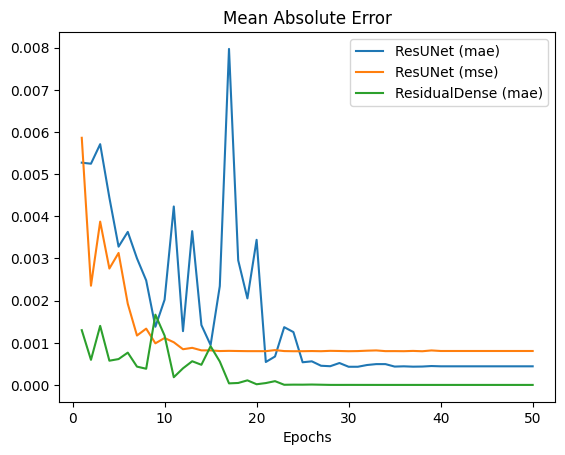

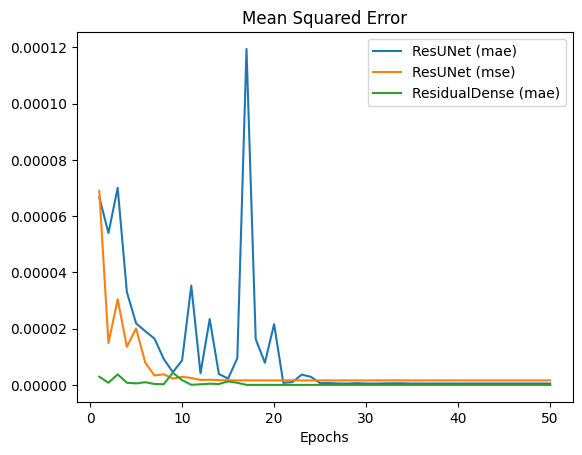

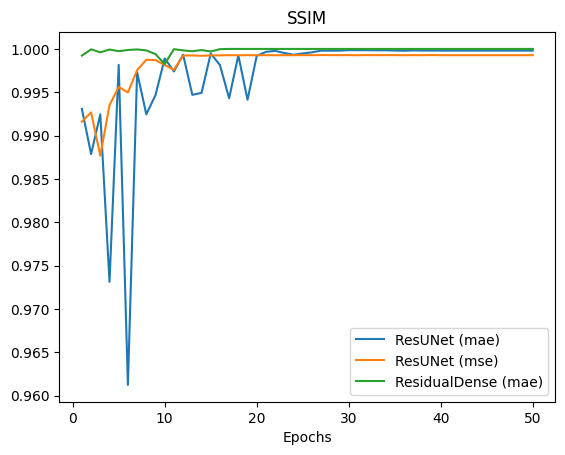

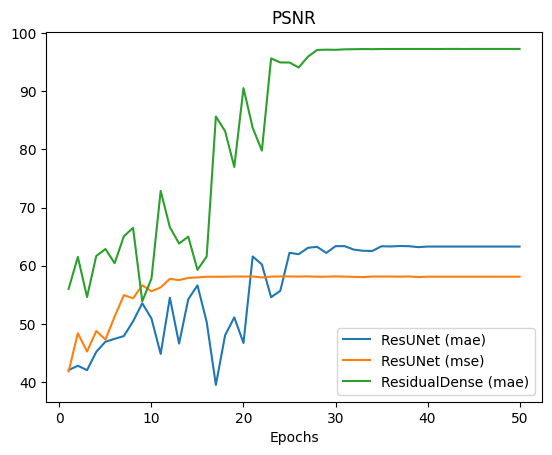

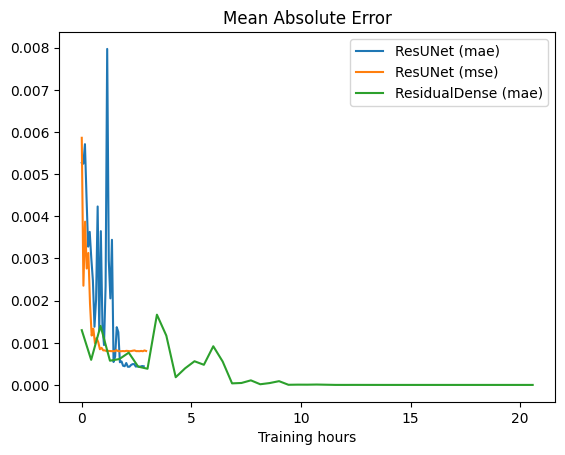

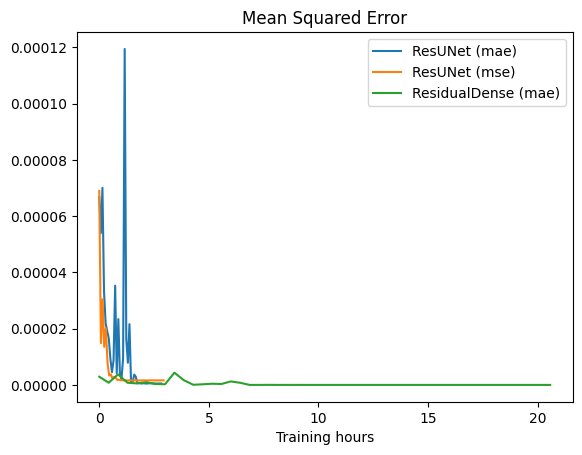

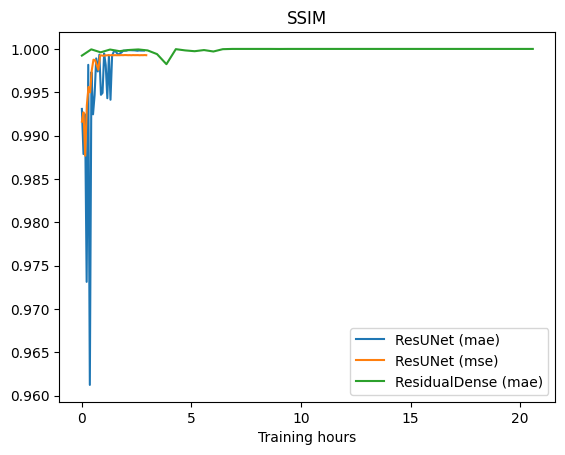

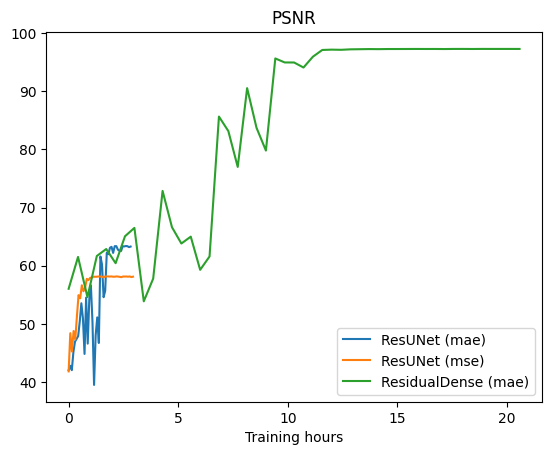

In [45]:
results = [
    {'label': 'ResUNet (mae)', 'path': 'experiment/resunet_mae/', 'epoch_duration': 261},
    {'label': 'ResUNet (mse)', 'path': 'experiment/resunet_mse/', 'epoch_duration': 271},
    #{'label': 'ResUNet (ssim)', 'path': 'experiment/resunet_ssim/', 'epoch_duration': 280},
    {'label': 'ResidualDense (mae)', 'path': 'experiment/rdn_mae/', 'epoch_duration': 1543},
    #{'label': 'ResidualDense (ssim)', 'path': 'experiment/rdn_ssim/', 'epoch_duration': 1543},
]
plotHistoryEpochs(results)
plotHistoryTime(results)

# Training with augmentation

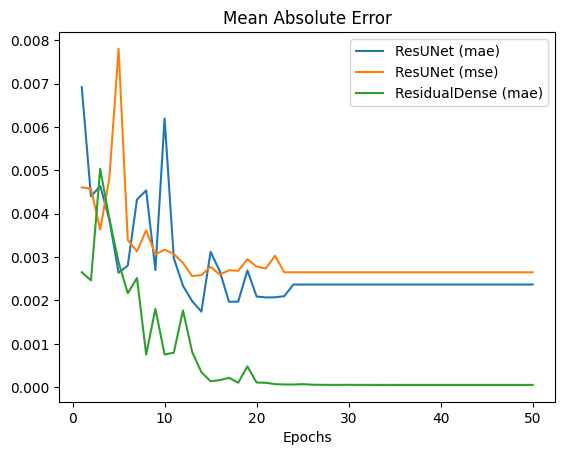

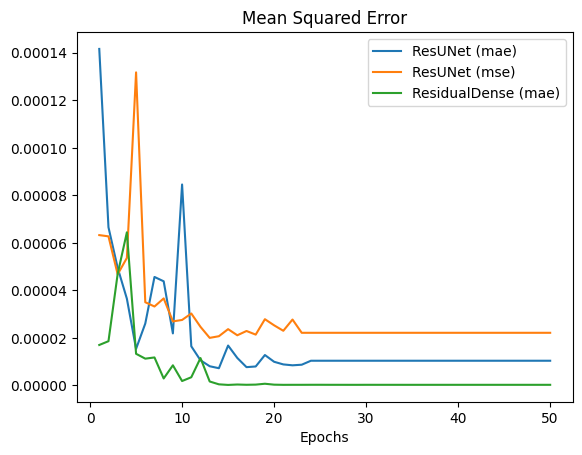

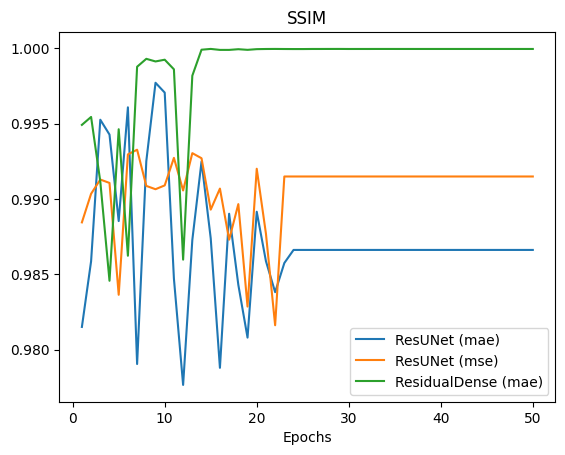

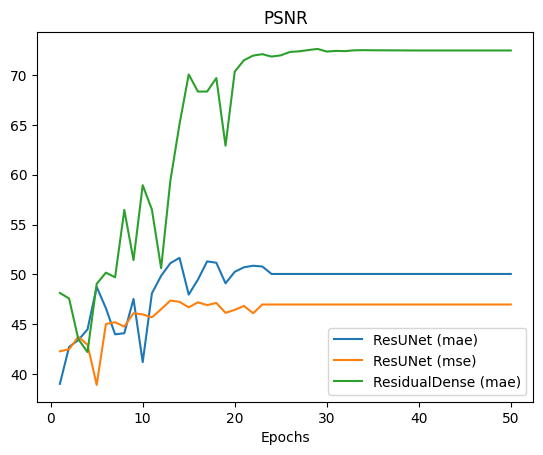

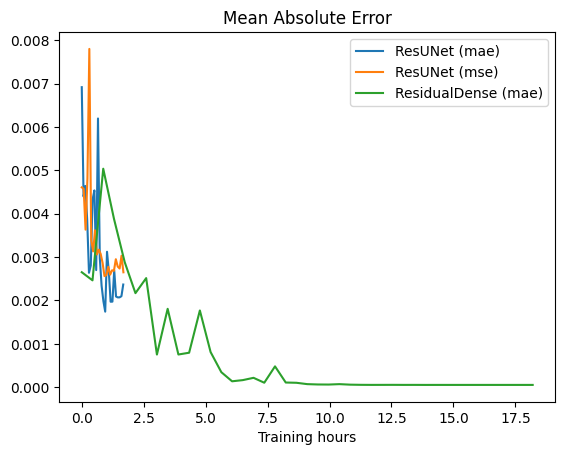

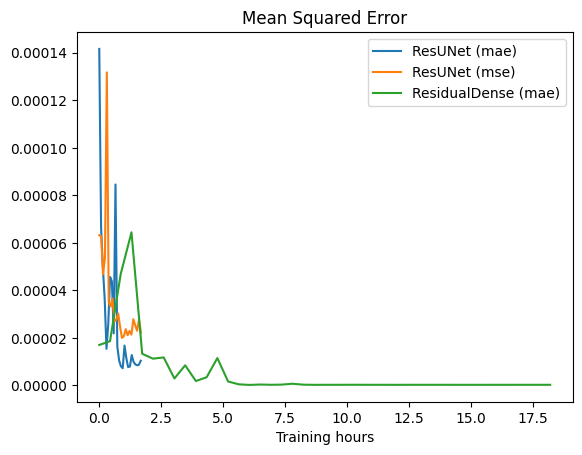

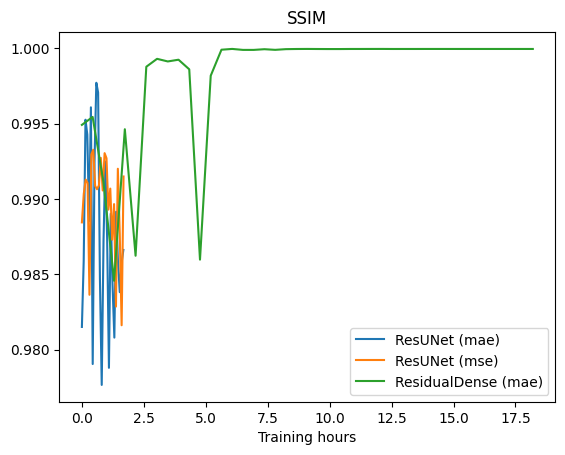

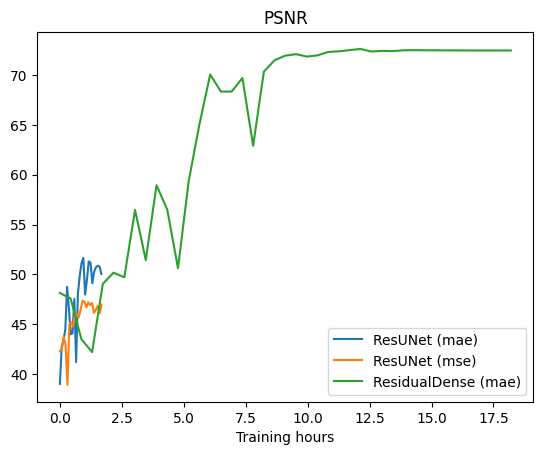

In [46]:
results = [
    {'label': 'ResUNet (mae)', 'path': 'experiment/resunet_mae_aug/', 'epoch_duration': 262},
    {'label': 'ResUNet (mse)', 'path': 'experiment/resunet_mse_aug/', 'epoch_duration': 275},
    #{'label': 'ResUNet (ssim)', 'path': 'experiment/resunet_ssim_aug/', 'epoch_duration': 261},
    {'label': 'ResidualDense (mae)', 'path': 'experiment/rdn_mae_aug/', 'epoch_duration': 1560},
    #{'label': 'ResidualDense (ssim)', 'path': 'experiment/rdn_ssim_aug/', 'epoch_duration': 1543},
]
plotHistoryEpochs(results)
plotHistoryTime(results)

# Sample reconstructed images

In [104]:
from models import getModel

def plotImages(trained_models, augment=False, sample=1):
    labels = ['Ground Truth']
    if augment:
        labels.append('Input Image')

    # Prepare test dataset
    test_ds = createDataset(test_files, 1, augment=augment, sample=sample)

    for trained_model in trained_models:
        # Create and compile model
        with tf.device('/CPU:0'):
            model = getModel(trained_model['name'])
            model.load_weights(trained_model['weights']).expect_partial()
            metrics = ['mae', 'mse', SSIM, PSNR]
            model.compile(metrics=metrics)
            trained_model['model'] = model
            labels.append(trained_model['label'])

    fig, ax1 = plt.subplots(sample, 1 + (1 if augment else 0) + len(trained_models), figsize = (128, 128))
    for ax, col in zip(ax1[0], labels):
        ax.set_title(col, fontsize=80)

    ii = 0
    for image, label in test_ds:
        ax1[ii][0].imshow(label[0], cmap ='bone')
        jj = 1
        if augment:
            ax1[ii][jj].imshow(image[0], cmap ='bone')
            jj += 1
        for trained_model in trained_models:
            predicted = trained_model['model'].predict(image, batch_size=1, verbose=0)
            ax1[ii][jj].imshow(predicted[0], cmap ='bone')
            jj += 1
        ii += 1
    plt.show()


## Without augmentation

In [106]:
trained_models = [
    {'label': 'ResUNet (mae)', 'name': 'resunet', 'weights': 'experiment/resunet_mae/bestWeigths.tf'},
    {'label': 'ResUNet (mse)', 'name': 'resunet', 'weights': 'experiment/resunet_mse/bestWeigths.tf'},
    #{'label': 'ResUNet (ssim)', 'name': 'resunet', 'weights': 'experiment/resunet_ssim/bestWeigths.tf'},
    {'label': 'Residual Dense (mae)', 'name': 'rdn', 'weights': 'experiment/rdn_mae/bestWeigths.tf'},
    #{'label': 'Residual Dense (ssim)', 'name': 'rdn', 'weights': 'experiment/rdn_ssim/bestWeigths.tf'},
]

plotImages(trained_models, sample=5)

## With augmentation

In [111]:
trained_models = [
    {'label': 'ResUNet (mae)', 'name': 'resunet', 'weights': 'experiment/resunet_mae_aug/bestWeigths.tf'},
    {'label': 'ResUNet (mse)', 'name': 'resunet', 'weights': 'experiment/resunet_mse_aug/bestWeigths.tf'},
    #{'label': 'ResUNet (ssim)', 'name': 'resunet', 'weights': 'experiment/resunet_ssim_aug/bestWeigths.tf'},
    {'label': 'Residual Dense (mae)', 'name': 'rdn', 'weights': 'experiment/rdn_mae_aug/bestWeigths.tf'},
    #{'label': 'Residual Dense (ssim)', 'name': 'rdn', 'weights': 'experiment/rdn_ssim_aug/bestWeigths.tf'},
]

plotImages(trained_models, augment=True, sample=5)

# Sample super-resolution

In [143]:
from models import getModel

def upscale(x, upscale_factor=2, filters=64, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    x = Conv2D(filters, 5, **conv_args)(x)
    x = Conv2D(filters, 3, **conv_args)(x)
    x = Conv2D(filters / 2, 3, **conv_args)(x)
    x = Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return outputs

def plotSRImages(trained_models, augment=False, sample=1):
    labels = ['Ground Truth']
    if augment:
        labels.append('Input Image')

    # Prepare test dataset
    test_ds = createDataset(test_files, 1, augment=augment, sample=sample)

    for trained_model in trained_models:
        # Create and compile model
        with tf.device('/CPU:0'):
            model = getModel(trained_model['name'])
            model.load_weights(trained_model['weights']).expect_partial()
            model.trainable=False
            inputs = model.inputs
            outputs = upscale(model.layers[-1].input)
            model = Model(inputs=inputs, outputs=outputs)
            model.load_weights(trained_model['weights2']).expect_partial()
            metrics = ['mae', 'mse', SSIM, PSNR]
            model.compile(metrics=metrics)
            trained_model['model'] = model
            labels.append(trained_model['label'])

    fig, ax1 = plt.subplots(sample, 1 + (1 if augment else 0) + len(trained_models), figsize = (256, 256))
    for ax, col in zip(ax1[0], labels):
        ax.set_title(col, fontsize=160)

    ii = 0
    for image, label in test_ds:
        ax1[ii][0].imshow(label[0], cmap ='bone')
        jj = 1
        if augment:
            ax1[ii][jj].imshow(image[0], cmap ='bone')
            jj += 1
        for trained_model in trained_models:
            predicted = trained_model['model'].predict(image, batch_size=1, verbose=0)
            ax1[ii][jj].imshow(predicted[0], cmap ='bone')
            jj += 1
        ii += 1
    plt.show()


In [144]:
trained_models = [
    {'label': 'ResUNet (mae)', 'name': 'resunet', 'weights': 'experiment/resunet_mae_aug/bestWeigths.tf', 'weights2': 'experiment/resunetSR_transfer_mae_aug/bestWeigths'},
    #{'label': 'ResUNet (mse)', 'name': 'resunet', 'weights': 'experiment/resunet_mse_aug/bestWeigths.tf', 'weights2': 'experiment/resunetSR_transfer_mse_aug/bestWeigths'},
    #{'label': 'ResUNet (ssim)', 'name': 'resunet', 'weights': 'experiment/resunet_ssim_aug/bestWeigths.tf', 'weights2': 'experiment/resunet_ssim_aug/bestWeigths'},
    {'label': 'Residual Dense (mae)', 'name': 'rdn', 'weights': 'experiment/rdn_mae_aug/bestWeigths.tf', 'weights2': 'experiment/rdnSR_transfer_mae_aug/bestWeigths'},
    #{'label': 'Residual Dense (ssim)', 'name': 'rdn', 'weights': 'experiment/rdn_ssim_aug/bestWeigths.tf', 'weights2': 'experiment/rdnSR_transfer_ssim_aug/bestWeigths'},
]

plotSRImages(trained_models, augment=True, sample=5)